# Analyse Network Results

In [125]:
import time
import math

import sys
import inspect
import os
import glob
import csv
import pandas as pd

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

mpl.style.use("seaborn")

sys.path.append("..")

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [87]:
def read_data(path):
    
    data = {}
    
    for filename in glob.glob(path+"/*csv"):
        
        # get networksize from name
        networksize = os.path.splitext(os.path.basename(filename))[0]
        
        # dataframework
        df = pd.read_csv(filename, header=None, delimiter=",")
        
        # expand dictionary with networksize as key and df as values
        data[networksize] = df[0].tolist()
        
    return data
        
acc_data = read_data("../evaluation")
print(acc_data.keys())

dict_keys(['LSTM_1x128_acc_test', 'LSTM_1x128_acc_time', 'LSTM_1x128_acc_train', 'LSTM_1x128_loss', 'LSTM_1x28_acc_test', 'LSTM_1x28_acc_time', 'LSTM_1x28_acc_train', 'LSTM_1x28_loss', 'LSTM_1x4_acc_test', 'LSTM_1x4_acc_time', 'LSTM_1x4_acc_train', 'LSTM_1x4_loss', 'LSTM_2x128_acc_test', 'LSTM_2x128_acc_time', 'LSTM_2x128_acc_train', 'LSTM_2x128_loss', 'LSTM_2x28_acc_test', 'LSTM_2x28_acc_time', 'LSTM_2x28_acc_train', 'LSTM_2x28_loss', 'LSTM_2x4_acc_test', 'LSTM_2x4_acc_time', 'LSTM_2x4_acc_train', 'LSTM_2x4_loss'])


## LSTM Architectures

In [119]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, n_characters):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.lstm(x, (h0,c0))
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

In [122]:
def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

### Accuracy vs Training Time

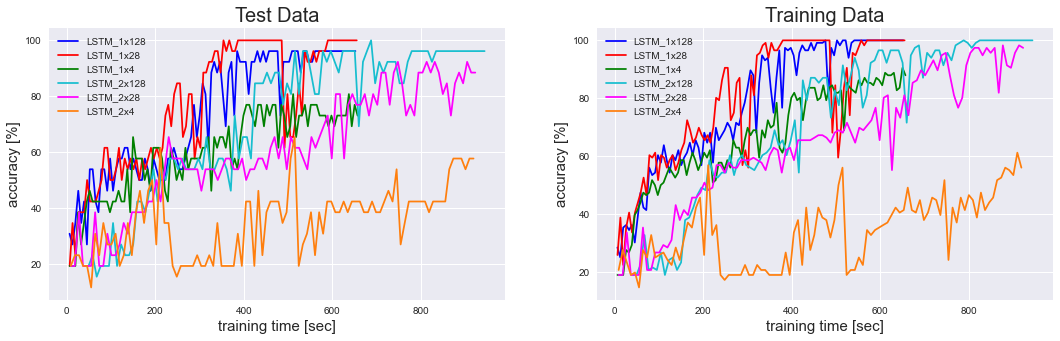

In [95]:
# create figure for accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18,5))


# create plot for Test Data
axs[0].plot(acc_data["LSTM_1x128_acc_time"], acc_data["LSTM_1x128_acc_test"], color="blue", label="LSTM_1x128")
axs[0].plot(acc_data["LSTM_1x28_acc_time"], acc_data["LSTM_1x28_acc_test"], color="red", label="LSTM_1x28")
axs[0].plot(acc_data["LSTM_1x4_acc_time"], acc_data["LSTM_1x4_acc_test"], color="green", label="LSTM_1x4")

axs[0].plot(acc_data["LSTM_2x128_acc_time"], acc_data["LSTM_2x128_acc_test"], color="tab:cyan", label="LSTM_2x128")
axs[0].plot(acc_data["LSTM_2x28_acc_time"], acc_data["LSTM_2x28_acc_test"], color="magenta", label="LSTM_2x28")
axs[0].plot(acc_data["LSTM_2x4_acc_time"], acc_data["LSTM_2x4_acc_test"], color="tab:orange", label="LSTM_2x4")

# title, labels and legend
axs[0].set_title("Test Data", fontsize=20)
axs[0].set_xlabel("training time [sec]", fontsize=15)
axs[0].set_ylabel("accuracy [%]", fontsize=15)
axs[0].legend()


# create plot for Training Data
axs[1].plot(acc_data["LSTM_1x128_acc_time"], acc_data["LSTM_1x128_acc_train"], color="blue", label="LSTM_1x128")
axs[1].plot(acc_data["LSTM_1x28_acc_time"], acc_data["LSTM_1x28_acc_train"], color="red", label="LSTM_1x28")
axs[1].plot(acc_data["LSTM_1x4_acc_time"], acc_data["LSTM_1x4_acc_train"], color="green", label="LSTM_1x4")

axs[1].plot(acc_data["LSTM_2x128_acc_time"], acc_data["LSTM_2x128_acc_train"], color="tab:cyan", label="LSTM_2x128")
axs[1].plot(acc_data["LSTM_2x28_acc_time"], acc_data["LSTM_2x28_acc_train"], color="magenta", label="LSTM_2x28")
axs[1].plot(acc_data["LSTM_2x4_acc_time"], acc_data["LSTM_2x4_acc_train"], color="tab:orange", label="LSTM_2x4")

# title, labels and legend
axs[1].set_title("Training Data", fontsize=20)
axs[1].set_xlabel("training time [sec]", fontsize=15)
axs[1].set_ylabel("accuracy [%]", fontsize=15)
axs[1].legend()


# show plot
plt.show()

### LOSS-Function

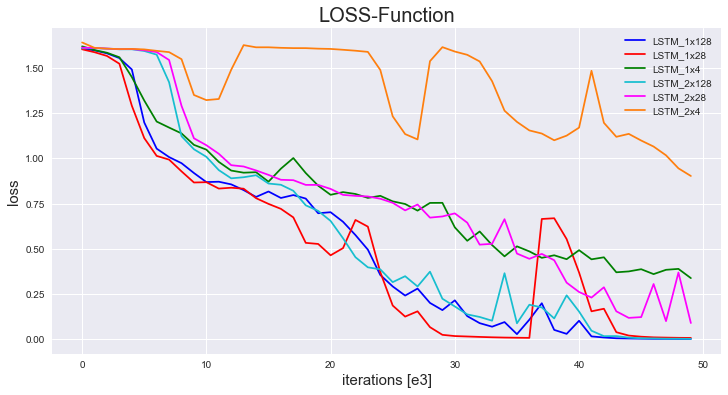

In [96]:
# create figure
plt.figure(figsize=(12,6))

# create plot
plt.plot(acc_data["LSTM_1x128_loss"], color="blue", label="LSTM_1x128")
plt.plot(acc_data["LSTM_1x28_loss"], color="red", label="LSTM_1x28")
plt.plot(acc_data["LSTM_1x4_loss"], color="green", label="LSTM_1x4")

plt.plot(acc_data["LSTM_2x128_loss"], color="tab:cyan", label="LSTM_2x128")
plt.plot(acc_data["LSTM_2x28_loss"], color="magenta", label="LSTM_2x28")
plt.plot(acc_data["LSTM_2x4_loss"], color="tab:orange", label="LSTM_2x4")

# title, labels and legend
plt.title("LOSS-Function", fontsize=20)
plt.xlabel("iterations [e3]", fontsize=15)
plt.ylabel("loss", fontsize=15)
plt.legend()

# show plot
plt.show()

### Confusion Matrices

In [138]:
def confusion_matrix():
    # load test dataset
    character_files, all_characters = load_data(path="../data/test/")
    #print("characters in test data: ", all_characters)

    # keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_characters, n_characters)

    with torch.no_grad():
        n_correct = 0
        n_samples = 0

        for character in all_characters:
            # all files from one character
            for file in character_files[character]:
                file_tensor = file_to_tensor(file).to(device)
                # get output
                output = loaded_model(file_tensor).to(device)
                # get character from output
                guess = character_from_output(output)
                n_samples += 1
                if guess == character:
                    n_correct += 1
                    correct = "✓"
                else:
                    correct = "✗ (%s)" % character
                confusion[all_characters.index(character)][all_characters.index(guess)] += 1

                #print(file, "/", guess, correct)

    # normalize by dividing every row by its sum
    for i in range(n_characters):
        confusion[i] = confusion[i] / confusion[i].sum()

    acc = 100.0 * n_correct / n_samples
    print(f"\naccuracy = {acc:.2f} %\n")

    # set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(False)
    cax = ax.matshow(confusion.numpy(), cmap="viridis")
    fig.colorbar(cax)

    # set up axes
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(all_characters, fontsize=11, rotation=90)
    ax.set_yticklabels(all_characters, fontsize=11)
    ax.set_xlabel("actual", fontsize=15)
    ax.xaxis.set_label_position("top") 
    ax.set_ylabel("predicted", fontsize=15)

    # force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

2.2.1-lstm-network-model-test-128x1.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 96.15 %



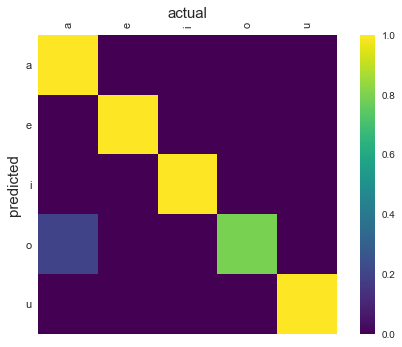

2.2.2-lstm-network-model-test-28x1.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 100.00 %



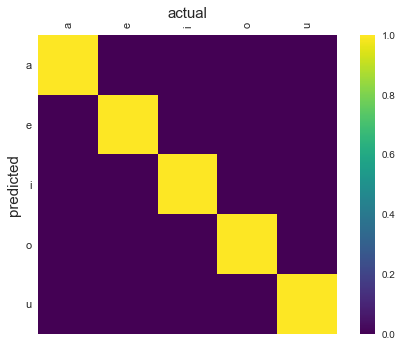

2.2.3-lstm-network-model-test-4x1.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 73.08 %



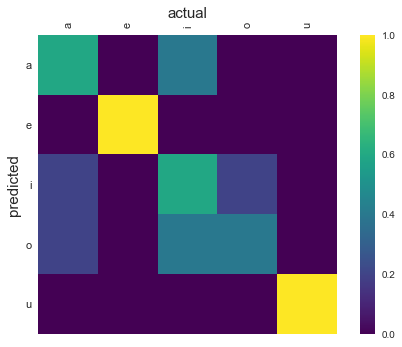

2.2.4-lstm-network-model-test-28x2.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 88.46 %



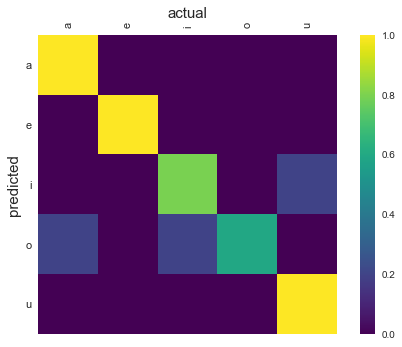

2.2.5-lstm-network-model-test-4x2.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 57.69 %



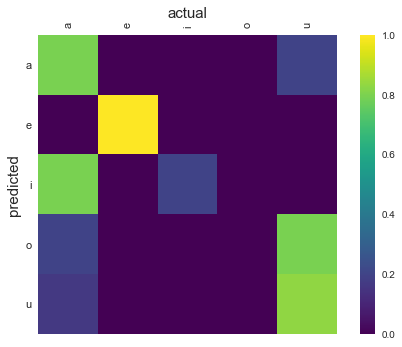

2.2.6-lstm-network-model-test-128x2.pth
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks

accuracy = 96.15 %



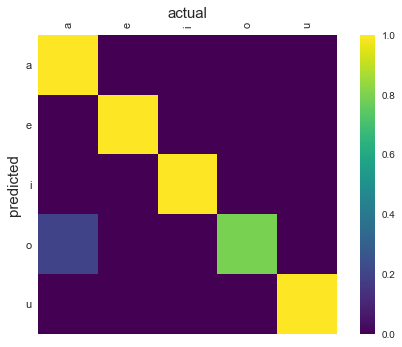

In [139]:
# fixed hyper paremeters
input_size = 3
n_characters = 5

for filename in glob.glob("../models/*.pth"):
    
    model = filename.split("\\")[1]
    
    if model[3] == ".":        
        # set model specific hyper parameters
        hidden_size = int(filename.split("-")[5].split("x")[0])
        n_layers = int(model[-5])
        
        print(model)
        
        %cd ../models/
        FILE = model
        loaded_model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)
        loaded_model.load_state_dict(torch.load(FILE, map_location=device))
        loaded_model.eval()
        %cd ../notebooks/
        
        confusion_matrix()

# RNN Architectures

### Accuracy vs Training Time

### LOSS-Function